In [14]:
%pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration to ignore clean-up warnings and set visual style
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Database Configuration (Neon Credentials)
DB_CONFIG = {
    'host': 'ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech',
    'port': 5432,
    'database': 'neondb',
    'user': 'neondb_owner',
    'password': 'a9Am7Yy5r9_T7h4OF2GN'
}

def create_connection():
    """Establish a professional connection to the NYC Schools database"""
    try:
        # Build connection string with SSL requirement
        conn_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}?sslmode=require"
        engine = create_engine(conn_url)
        
        # Test connection
        with engine.connect() as conn:
            print("✅ Connection successful: SQLAlchemy engine is ready.")
        return engine
    except Exception as e:
        print(f"❌ Connection failed: {e}")
 

# Initialize the engine
engine = create_connection()


✅ Connection successful: SQLAlchemy engine is ready.


In [35]:
query = "SELECT * FROM nyc_schools.high_school_directory LIMIT 5;"
df = pd.read_sql(query, engine)
df.head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,number_programs,Location 1,Community Board,Council District,Census Tract,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,None,None,...,1,"{'latitude': '40.601989336', 'longitude': '-73...",14,31,100802,20529,51,3,47,59
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,None,None,...,1,"{'latitude': '40.593593811', 'longitude': '-73...",13,47,306,17616,21,2,45,35
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,None,None,...,1,"{'latitude': '40.692133704', 'longitude': '-73...",3,36,291,18181,69,2,49,52
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,None,None,...,1,"{'latitude': '40.822303765', 'longitude': '-73...",9,18,16,11611,58,5,31,26
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,None,None,...,6,"{'latitude': '40.773670507', 'longitude': '-73...",7,6,151,12420,20,4,19,12


In [17]:
with engine.connect() as connection:
    connection.rollback()
    print("✅ Conexión reseteada. Ahora puedes ejecutar tus consultas.")

✅ Conexión reseteada. Ahora puedes ejecutar tus consultas.


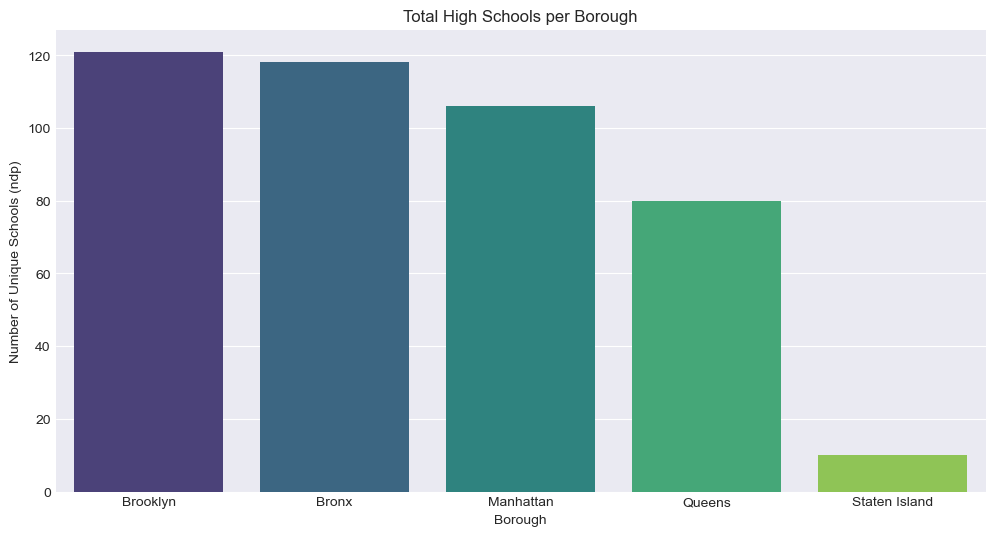

Total High schools per Borough


,borough,ndp
0,Brooklyn,121
1,Bronx,118
2,Manhattan,106
3,Queens,80
4,Staten Island,10


In [32]:
# Query 1: Distribution of schools per Council Disrict
query_1 = """
SELECT borough, COUNT(DISTINCT dbn) AS ndp
FROM nyc_schools.high_school_directory
GROUP BY borough
ORDER BY ndp DESC;
"""

# Visualitazion
df_boroughs = pd.read_sql(query_1, engine)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_boroughs, x='borough', y='ndp', palette='viridis')
plt.title('Total High Schools per Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Unique Schools (ndp)')
plt.show()
print("Total High schools per Borough")
display(df_boroughs.head())

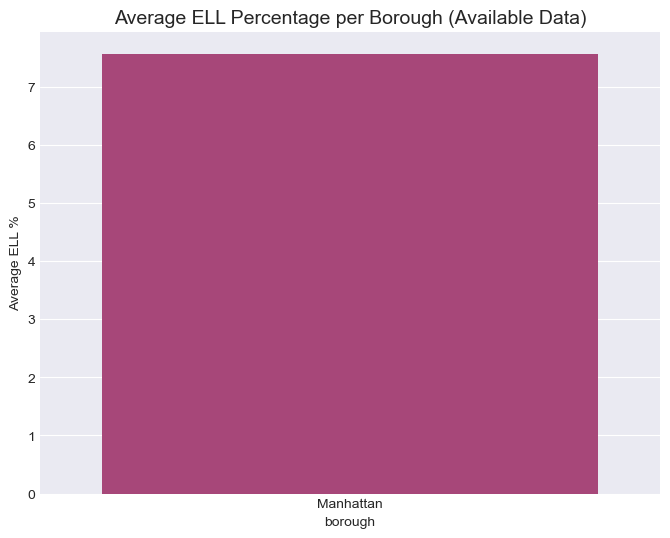

Average ELL Percentage per District:


,borough,avg_ell_percent
0,Manhattan,7.57


In [44]:
# Query 2: Average ELL percentage per Borough
query_2 = """
SELECT dir.borough, 
       ROUND(AVG(demo.ell_percent)::numeric, 2) AS avg_ell_percent
FROM nyc_schools.high_school_directory dir
JOIN nyc_schools.school_demographics demo ON dir.dbn = demo.dbn
GROUP BY dir.borough
ORDER BY avg_ell_percent DESC;
"""

df_ell_borough = pd.read_sql(query_2, engine)
df_ell_clean = df_ell_borough.dropna(subset=['avg_ell_percent'])
# Visualitazion
plt.figure(figsize=(8, 6))
sns.barplot(data=df_ell_borough, x='borough', y='avg_ell_percent', palette='magma')
plt.title('Average ELL Percentage per Borough (Available Data)', fontsize=14)
plt.ylabel('Average ELL %')
plt.show()
print("Average ELL Percentage per District:")
display(df_ell_clean)

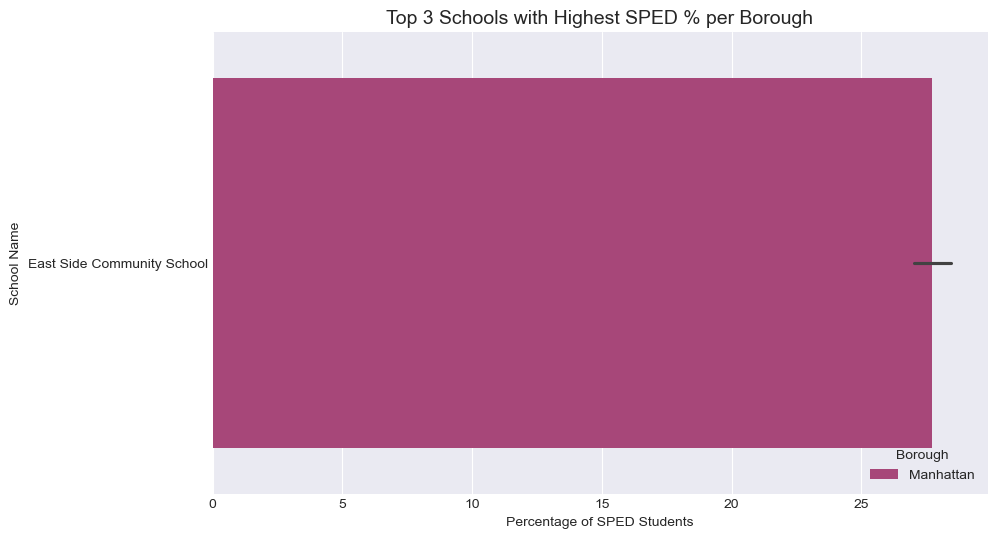

Top 3 Schools with Highest Sped % per Borough


,borough,school_name,sped_percent
0,Manhattan,East Side Community School,28.8
1,Manhattan,East Side Community School,27.7
2,Manhattan,East Side Community School,26.7


In [11]:
# Query 3: Top 3 schools by SPED % per Borough
query_3 = """
WITH RankedSped AS (
    SELECT 
        dir.borough,
        dir.school_name,
        demo.sped_percent,
        ROW_NUMBER() OVER(PARTITION BY dir.borough ORDER BY demo.sped_percent DESC) as rank
    FROM nyc_schools.high_school_directory dir
    JOIN nyc_schools.school_demographics demo ON dir.dbn = demo.dbn
)
SELECT borough, school_name, sped_percent
FROM RankedSped
WHERE rank <= 3
ORDER BY borough, sped_percent DESC;
"""

df_sped_borough = pd.read_sql(query_3, engine)
# Visualitazion
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sped_borough, x='sped_percent', y='school_name', hue='borough', dodge=False, palette='magma')
plt.title('Top 3 Schools with Highest SPED % per Borough', fontsize=14)
plt.xlabel('Percentage of SPED Students')
plt.ylabel('School Name')
plt.legend(title='Borough', loc='lower right')
plt.show()
print("Top 3 Schools with Highest Sped % per Borough")
display(df_sped_borough.head())

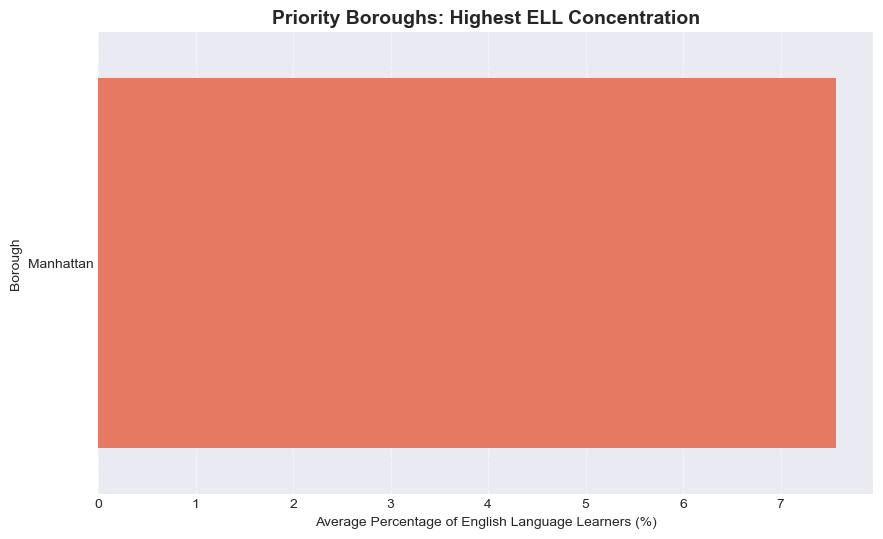

Evidence Data Table:


,Borough,Average ELL %
0,Manhattan,7.57


In [12]:
# Priority Boroughs Highest ELL Concentration
top_ell_boroughs = df_ell_borough.copy()
top_ell_boroughs.columns = ['Borough', 'Average ELL %']

# 2. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=top_ell_boroughs, x='Average ELL %', y='Borough', palette='Reds_r')

plt.title('Priority Boroughs: Highest ELL Concentration', fontsize=14, fontweight='bold')
plt.xlabel('Average Percentage of English Language Learners (%)')
plt.ylabel('Borough')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print("Evidence Data Table:")
display(top_ell_boroughs)